In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage import io
import cv2
import os
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn

# Create Tiles

In [2]:
def create_tiles(I, tile_size = 128, r_offset = 0, c_offset = 0, n = 12, ipr = 4):
    """
    Params:
        tile_size: n x n pixels per tile
        r_offset: tiling starts n pixels left of input image left edge
        c_offset: tiling: starts n pixels above input image top edge
        n: total number of tiles in final stitched image
        ipr: images per row in final stitched image
    Returns:
        final stitched image
    """
    
    start_time = time.time()

    img = image[-1]
    r, c, d = np.shape(img)


    #left side offset padding
    left_pad = np.uint8(np.ones((r, r_offset, d)) * 255)
    img_lp = np.concatenate((left_pad, img),1)

    #build right-side padding
    rn, cn, d = np.shape(img_lp)
    right_pad_amt = tile_size - cn%tile_size
    right_pad = np.uint8(np.ones((rn, right_pad_amt,d)) * 255)
    img_lrp = np.concatenate((img_lp,right_pad),1)

    # top side offset padding
    rn2, cn2, d = np.shape(img_lrp)
    top_pad = np.uint8(np.ones((c_offset, cn2, d)) * 255)
    img_lrtp = np.concatenate((top_pad, img_lrp),0)

    #build bottom-side padding
    rn3, cn3, d = np.shape(img_lrtp)
    bot_pad_amt = tile_size - rn3%tile_size
    bot_pad = np.uint8(np.ones((bot_pad_amt,cn3,d))*255)
    img_lrtbp = np.concatenate((img_lrtp,bot_pad),0)

    np.shape(img_lrtbp)

    im = img_lrtbp
    M = tile_size
    N = tile_size
    tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
    tiles = np.array(tiles)

    num_tiles = len(tiles)
    counts = np.zeros(num_tiles)
    for img_num in range(num_tiles):
        counts[img_num] = (tiles[img_num]<255).sum()
    tile_idx = np.argsort(counts)[-n:]
    sub_tiles = tiles[tile_idx]

    #stick the subtiles together
    x = 4
    y = 3
    tape = np.uint8(np.zeros((tile_size,0,3)))
    for i in range(n):
        tape = np.concatenate((tape,sub_tiles[i]),1)

    num_rows = n/ipr
    cols = np.shape(tape)
    final_img = np.uint8(np.zeros((0,ipr*tile_size,3)))
    idx = 0
    for i in range(int(num_rows)):

        final_img = np.concatenate((final_img, tape[0:tile_size,idx*tile_size*ipr:(idx+1)*tile_size*ipr,:]),0)
        idx = idx + 1





    print("--- %s seconds ---" % (time.time() - start_time))
    return final_img

# Original Slide Image

Image Dim: (2160, 1792, 3)


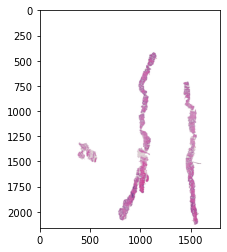

In [3]:
#Read in and display an image
I = '/kaggle/input/prostate-cancer-grade-assessment/train_images/001d865e65ef5d2579c190a0e0350d8f.tiff'
image = io.MultiImage(I)
print('Image Dim: ' +  str(np.shape(image[-1])))
img = image[-1]
plt.imshow(img);

# Tiled Image

--- 0.09886407852172852 seconds ---
Total num pizels: 196608
Percent of total biopsy area captured by tiled images: 44.0%
Percent of tiled images area covered by biopsy (1-%whitespace): 56.0%


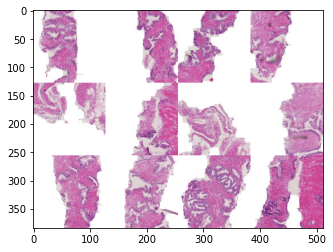

In [4]:
image = io.MultiImage(I)
tiled_img = create_tiles(image, tile_size = 128, r_offset = 0, c_offset = 0, n = 12, ipr = 4)
plt.imshow(tiled_img);

mask = np.sum(image[-1],-1) < 765
mask2 = np.sum(tiled_img,-1) < 765

r,c = np.shape(mask2)
print('Total num pizels: ' + str(r*c))
print('Percent of total biopsy area captured by tiled images: ' + str(round(mask2.sum()/mask.sum()* 100,0 )) + '%')
print('Percent of tiled images area covered by biopsy (1-%whitespace): ' + str(round(mask2.sum()/(r*c)* 100,0)) + '%')


--- 0.048409223556518555 seconds ---
Total num pizels: 322560
Percent of total biopsy area captured by tiled images: 81.0%
Percent of tiled images area covered by biopsy (1-%whitespace): 62.0%


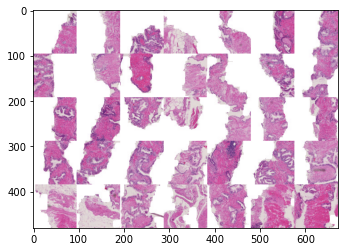

In [5]:
tiled_img = create_tiles(image, tile_size = 96, r_offset = 0, c_offset = 0, n = 35, ipr = 7)
plt.imshow(tiled_img);

mask = np.sum(image[-1],-1) < 765
mask2 = np.sum(tiled_img,-1) < 765

r,c = np.shape(mask2)
print('Total num pizels: ' + str(r*c))
print('Percent of total biopsy area captured by tiled images: ' + str(round(mask2.sum()/mask.sum()* 100,0 )) + '%')
print('Percent of tiled images area covered by biopsy (1-%whitespace): ' + str(round(mask2.sum()/(r*c)* 100,0)) + '%')

### The goal is to find the combination of tile size and number of tiles which gives: 
* the greatest value for % of total biopsy captured by tiled images
* the greatest values for % of tiled image area covered by biopsy (1 - %whitespace)
* the smallest value for tile size - the smaller this value, the more spatial information lost


For slide 001d865e65ef5d2579c190a0e0350d8f:

| tile size| # tiles  | # pixels/3 |% of total biopsy area captured by tiled images | Percent of tiled images area covered by biopsy (1-%whitespace) |
|------|------|------|------| ------|
| 128 | 12 | 196608 |44 | 56 |
| 128 | 16 | 262144 |56 | 53 |
| 128 | 20 | 327680 | 65 | 20 |
| 64 | 60 | 245760 |76 | 77 |
| 96 | 35 | 322560 |81 | 62 |